# 15 PDEs: Solution with Time Stepping

## Heat Equation
The **heat equation** can be derived from Fourier's law and energy conservation (see the [lecture notes on the heat equation (PDF)](https://github.com/ASU-CompMethodsPhysics-PHY494/PHY494-resources/blob/master/15_PDEs/15_PDEs_LectureNotes_HeatEquation.pdf))

$$
\frac{\partial T(\mathbf{x}, t)}{\partial t} = \frac{K}{C\rho} \nabla^2 T(\mathbf{x}, t),
$$

## Problem: insulated metal bar (1D heat equation)
A metal bar of length $L$ is insulated along it lengths and held at 0ºC at its ends. Initially, the whole bar is at 100ºC. Calculate $T(x, t)$ for $t>0$.

### Analytic solution
Solve by separation of variables and power series: The general solution that obeys the boundary conditions $T(0, t) = T(L, t) = 0$ is

$$
T(x, t) = \sum_{n=1}^{+\infty} A_n \sin(k_n x)\, \exp\left(-\frac{k_n^2 K t}{C\rho}\right), \quad k_n = \frac{n\pi}{L}
$$

The specific solution that satisfies $T(x, 0) = T_0 = 100^\circ\text{C}$ leads to $A_n = 4 T_0/n\pi$ for $n$ odd:

$$
T(x, t) = \sum_{n=1,3,5,\dots}^{+\infty} \frac{4 T_0}{n \pi} \sin(k_n x)\, \exp\left(-\frac{k_n^2 K t}{C\rho}\right)
$$

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [39]:
def T_bar(x, t, T0, L, K=237, C=900, rho=2700, nmax=1000):
    T = np.zeros_like(x)
    eta = K / (C*rho)
    for n in range(1, nmax, 2):
        kn = n*np.pi/L
        T += 4*T0/(np.pi * n) * np.sin(kn*x) * np.exp(-kn*kn * eta * t)
    return T

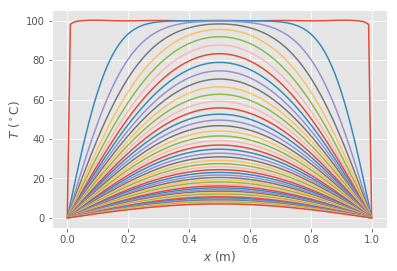

In [40]:
T0 = 100.
L = 1.0
X = np.linspace(0, L, 100)
for t in np.linspace(0, 3000, 50):
    plt.plot(X, T_bar(X, t, T0, L))
plt.xlabel(r"$x$ (m)")
plt.ylabel(r"$T$ ($^\circ$C)");

### Numerical solution: Leap frog
Discretize (finite difference):

For the time domain we only have the initial values so we use a simple forward difference for the time derivative:

$$
\frac{\partial T(x,t)}{\partial t} \approx \frac{T(x, t+\Delta t) - T(x, t)}{\Delta t}
$$

For the spatial derivative we have initially all values so we can use the more accurate central difference approximation:

$$
\frac{\partial^2 T(x, t)}{\partial x^2} \approx \frac{T(x+\Delta x, t) + T(x-\Delta x, t) - 2 T(x, t)}{\Delta x^2}
$$

Thus, the heat equation can be written as the finite difference equation

$$
\frac{T(x, t+\Delta t) - T(x, t)}{\Delta t} = \frac{K}{C\rho} \frac{T(x+\Delta x, t) + T(x-\Delta x, t) - 2 T(x, t)}{\Delta x^2}
$$

which can be reordered so that the RHS contains only known terms and the LHS future terms. Index $i$ is the spatial index, and $j$ the time index: $x = x_0 + i \Delta x$, $t = t_0 + j \Delta t$.

$$
T_{i, j+1} = (1 - 2\eta) T_{i,j} + \eta(T_{i+1,j} + T_{i-1, j}), \quad \eta := \frac{K \Delta t}{C \rho \Delta x^2}
$$

Thus we can step forward in time ("leap frog"), using only known values.

### Solve the 1D heat equation numerically for an iron bar
* $K = 237$ W/mK
* $C = 900$ J/K
* $\rho = 2700$ kg/m<sup>3</sup>
* $L = 1$ m
* $T_0 = 373$ K and $T_b = 273$ K
* $T(x, 0) = T_0$ and $T(0, t) = T(L, t) = T_b$

#### Key considerations 

The key line is the computation of the new temperature field at time step $j+1$ from the temperature distribution at time step $j$. It can be written purely with numpy array operations (see last lecture!):

```python
T[1:-1] = (1 - 2*eta) * T[1:-1] + eta * (T[2:] + T[:-2])
```

Note that the range operator `T[start:end]` *excludes* `end`, so in order to include `T[1], T[2], ..., T[-2]` (but not the rightmost `T[-1]`) we have to use `T[1:-1]`.

The *boundary conditions* are fixed for all times:
```python
T[0] = T[-1] = Tb
```

The *initial conditions* (at time step `j=0`)
```python
T[1:-1] = T0
```
are only used to compute the distribution of temperatures at the next step `j=1`.

#### Solution

In [5]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

For HTML/nbviewer output, use inline:

In [6]:
%matplotlib inline

In [7]:
L_rod = 1.    # m
t_max = 3000. # s

Dx = 0.02   # m
Dt = 2    # s

Nx = int(L_rod // Dx)
Nt = int(t_max // Dt)

Kappa = 237 # W/(m K)
CHeat = 900 # J/K
rho = 2700  # kg/m^3

T0 = 373 # K
Tb = 273 # K

eta = Kappa * Dt / (CHeat * rho * Dx**2)
eta2 = 1 - 2*eta

step = 20  # plot solution every n steps

print("Nx = {0}, Nt = {1}".format(Nx, Nt))
print("eta = {0}".format(eta))

T = np.zeros(Nx)
T_plot = np.zeros((Nt//step + 1, Nx))

# initial conditions
T[1:-1] = T0
# boundary conditions
T[0] = T[-1] = Tb

t_index = 0
T_plot[t_index, :] = T
for jt in range(1, Nt):
    T[1:-1] = eta2 * T[1:-1] + eta*(T[2:] + T[:-2])
    if jt % step == 0 or jt == Nt-1:
        t_index += 1
        T_plot[t_index, :] = T
        print("Iteration {0:5d}".format(jt), end="\r")
else:
    print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))

Nx = 49, Nt = 1500
eta = 0.4876543209876543
Completed  1499 iterations: t=2998 s


#### Visualization
Visualize (you can use the code as is). 

Note how we are making the plot use proper units by mutiplying with `Dt * step` and `Dx`.

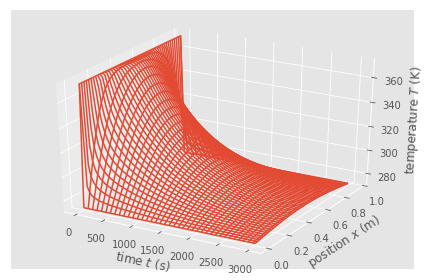

In [8]:
X, Y = np.meshgrid(range(T_plot.shape[0]), range(T_plot.shape[1]))
Z = T_plot[X, Y]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_wireframe(X*Dt*step, Y*Dx, Z)
ax.set_xlabel(r"time $t$ (s)")
ax.set_ylabel(r"position $x$ (m)")
ax.set_zlabel(r"temperature $T$ (K)")
fig.tight_layout()

2D as above for the analytical solution…

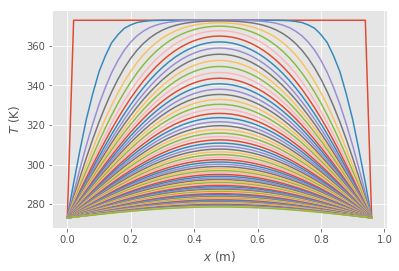

In [37]:
X = Dx * np.arange(T_plot.shape[1])
plt.plot(X, T_plot.T)
plt.xlabel(r"$x$ (m)")
plt.ylabel(r"$T$ (K)");

#### Slower solution 

I benchmarked this slow solution at 89.7 ms and the fast solution at 14.8 ms (commented out all `print`) so the explicit loop is not that much worse (probably because the overhead on array copying etc is high).

In [9]:
L_rod = 1.    # m
t_max = 3000. # s

Dx = 0.02   # m
Dt = 2    # s

Nx = int(L_rod // Dx)
Nt = int(t_max // Dt)

Kappa = 237 # W/(m K)
CHeat = 900 # J/K
rho = 2700  # kg/m^3

T0 = 373 # K
Tb = 273 # K

eta = Kappa * Dt / (CHeat * rho * Dx**2)
eta2 = 1 - 2*eta

step = 20  # plot solution every n steps

print("Nx = {0}, Nt = {1}".format(Nx, Nt))
print("eta = {0}".format(eta))

T = np.zeros(Nx)
T_new = np.zeros_like(T)
T_plot = np.zeros((int(np.ceil(Nt/step)) + 1, Nx))

# initial conditions
T[1:-1] = T0
# boundary conditions
T[0] = T[-1] = Tb

T_new[:] = T

t_index = 0
T_plot[t_index, :] = T
for jt in range(1, Nt):
    # T[1:-1] = eta2 * T[1:-1] + eta*(T[2:] + T[:-2])
    for ix in range(1, Nx-1):
        T_new[ix] = eta2 * T[ix] + eta*(T[ix+1] + T[ix-1])
    T[:] = T_new
    if jt % step == 0 or jt == Nt-1:
        t_index += 1
        T_plot[t_index, :] = T
        print("Iteration {0:5d}".format(jt), end="\r")
else:
    print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))

Nx = 49, Nt = 1500
eta = 0.4876543209876543
Completed  1499 iterations: t=2998 s


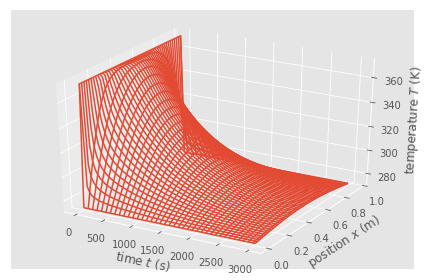

In [10]:
X, Y = np.meshgrid(range(T_plot.shape[0]), range(T_plot.shape[1]))
Z = T_plot[X, Y]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_wireframe(X*Dt*step, Y*Dx, Z)
ax.set_xlabel(r"time $t$ (s)")
ax.set_ylabel(r"position $x$ (m)")
ax.set_zlabel(r"temperature $T$ (K)")
fig.tight_layout()

## Stability of the solution

### Empirical investigation of the stability
Investigate the solution for different values of `Dt` and `Dx`. Can you discern patters for stable/unstable solutions?

Report `Dt`, `Dx`, and `eta`
* for 3 stable solutions 
* for 3 unstable solutions


In [11]:
def calculate_T(L_rod=1, t_max=3000, Dx=0.02, Dt=2, T0=373, Tb=273,
               step=20):
    Nx = int(L_rod // Dx)
    Nt = int(t_max // Dt)

    Kappa = 237 # W/(m K)
    CHeat = 900 # J/K
    rho = 2700  # kg/m^3

    eta = Kappa * Dt / (CHeat * rho * Dx**2)
    eta2 = 1 - 2*eta

    print("Nx = {0}, Nt = {1}".format(Nx, Nt))
    print("eta = {0}".format(eta))

    T = np.zeros(Nx)
    T_plot = np.zeros((int(np.ceil(Nt/step)) + 1, Nx))

    # initial conditions
    T[1:-1] = T0
    # boundary conditions
    T[0] = T[-1] = Tb

    t_index = 0
    T_plot[t_index, :] = T
    for jt in range(1, Nt):
        T[1:-1] = eta2 * T[1:-1] + eta*(T[2:] + T[:-2])
        if jt % step == 0 or jt == Nt-1:
            t_index += 1
            T_plot[t_index, :] = T
            print("Iteration {0:5d}".format(jt), end="\r")
    else:
        print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))
    return T_plot

def plot_T(T_plot, Dx, Dt, step):
    X, Y = np.meshgrid(range(T_plot.shape[0]), range(T_plot.shape[1]))
    Z = T_plot[X, Y]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(X*Dt*step, Y*Dx, Z)
    ax.set_xlabel(r"time $t$ (s)")
    ax.set_ylabel(r"position $x$ (m)")
    ax.set_zlabel(r"temperature $T$ (K)")
    fig.tight_layout()
    return ax

Nx = 99, Nt = 1500
eta = 1.9506172839506173
Completed  1499 iterations: t=2998 s


/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in multiply
/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in add


/Users/oliver/anaconda3/lib/python3.5/site-packages/mpl_toolkits/mplot3d/proj3d.py:160: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


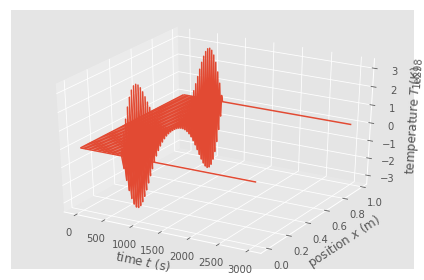

In [12]:
T_plot = calculate_T(Dx=0.01, Dt=2, step=20)
plot_T(T_plot, 0.01, 2, 20)

Note that *decreasing* the value of $\Delta x$ made the solution *unstable*. This is strange, we have gotten used to the idea that working on a finer mesh will increase the detail (until we hit round-off error) and just become computationally more expensive. But here the algorithm suddenly becomes unstable (and it is not just round-off).

For certain combination of values of $\Delta t$ and $\Delta x$ the solution become unstable. Empirically, bigger $\eta$ leads to instability. (In fact, $\eta \geq \frac{1}{2}$ is unstable for the leapfrog algorithm as we will see.)

### Von Neumann stability analysis 

If the difference equation solution diverges then we *know* that we have a bad approximation to the original PDE. 

Von Neumann stability analysis starts from the assumption that *eigenmodes* of the difference equation can be written as

$$
T_{m,j} = \xi(k)^j e^{ikm\Delta x}, \quad t=j\Delta t,\ x=m\Delta x 
$$

with the unknown wave vectors $k=2\pi/\lambda$ and unknown complex functions – the *amplification factors* – $\xi(k)$.

Solutions of the difference equation can be written as linear superpositions of these basis functions. But they are only stable if the eigenmodes are stable, i.e., will not grow in time (with $j$). This is the case when 

$$
|\xi(k)| < 1
$$

for all $k$.

Insert the eigenmodes into the finite difference equation

$$
T_{m, j+1} = (1 - 2\eta) T_{m,j} + \eta(T_{m+1,j} + T_{m-1, j})
$$

to obtain 

\begin{align}
\xi(k)^{j+1} e^{ikm\Delta x} &= (1 - 2\eta) \xi(k)^{j} e^{ikm\Delta x} 
    + \eta(\xi(k)^{j} e^{ik(m+1)\Delta x} + \xi(k)^{j} e^{ik(m-1)\Delta x})\\
\xi(k) &= (1 - 2\eta) + \eta(e^{ik\Delta x} + e^{-ik\Delta x})\\
\xi(k) &= 1 - 2\eta + 2\eta \cos k\Delta x\\
\xi(k) &= 1 + 2\eta\big(\cos k\Delta x - 1\big)
\end{align}

For $|\xi(k)| < 1$ (and all possible $k$):

\begin{align}
|\xi(k)| < 1 \quad &\Leftrightarrow \quad \xi^2(k) < 1\\
(1 + 2y)^2 = 1 + 4y + 4y^2 &< 1 \quad \text{with}\ \  y = \eta(\cos k\Delta x - 1)\\
y(1 + y) &< 0 \quad \Leftrightarrow \quad -1 < y < 0\\
\eta(\cos k\Delta x - 1) &\leq 0 \quad \forall k \quad (\eta > 0, -1 \leq \cos x \leq 1)\\
\eta(\cos k\Delta x - 1) &> -1\\
\eta &< \frac{1}{1 - \cos k\Delta x}\\
\eta = \frac{K \Delta t}{C \rho \Delta x^2} &< \frac{1}{2} \le \frac{1}{1 - \cos k\Delta x}
\end{align}

Thus, solutions are only stable for $\eta < 1/2$. In particular, decreasing $\Delta t$ will always improve stability, But decreasing $\Delta x$ requires an quadratic *increase* in $\Delta t$!

Note
* Perform von Neumann stability analysis when possible (depends on PDE and the specific discretization).
* Test different combinations of $\Delta t$ and $\Delta x$.
* Not guarantee that decreasing both will lead to more stable solutions!

Check my inputs:

This was stable and it conforms to the stability criterion:

In [41]:
Dt = 2
Dx = 0.02
eta = Kappa * Dt /(CHeat * rho * Dx*Dx)
print(eta)

0.4876543209876543


... and this was unstable, despite a seemingly small change:

In [42]:
Dt = 2
Dx = 0.01
eta = Kappa * Dt /(CHeat * rho * Dx*Dx)
print(eta)

1.9506172839506173
